# Log File Anomaly Detection

**Company Use Case:**

Due to the potential presence of sensitive patient data, log files cannot be shared or processed on the cloud directly. Homomorphic encryption comes into play by encrypting the log files and enabling predictive filtering of sensitive lines within them. This approach ensures data privacy while allowing for the extraction of valuable insights, particularly beneficial for enhancing predictive maintenance efforts.

**Approach:**

Since it's unknown which sensitive information could be contained in the log files the goal is to implement an anomaly detection algorithm which is trained on "normal samples" (_notice_ & _warn_ logs)

The following Notebook will show two approaches to do this with ConcreteML.

**Dataset Source:**

The data used is provided by Loghub, which maintains a collection of system logs that are freely accessible for AI-driven log analytics research . The logs are a combination of production data released from previous studies and real systems in their lab environment. The logs are not sanitized, anonymized, or modified in any way, wherever possible. These log datasets are freely available for research or academic work.

https://github.com/logpai/loghub/tree/master

**Dataset  1:**

_Android_

Loghub Description:

Android (https://www.android.com) is a popular open-source mobile operating system and has been used by many smart devices. However, Android logs are rarely available in public for research purposes. We provide some Android log files, which were collected by Android smartphones with heavily instrumented modules installed. The Android architecture comprises of five levels, including the Linux Kernel, Libraries, Application Framework, Android Runtime, and System Applications. We provide a sample log file printed by the Application Framework.

Training on logs: [Info (I), Debug (D), Verbose (V)]

Test detecting: [Warn (W), Error (E)]

https://github.com/logpai/loghub/blob/master/Android/Android_2k.log_structured.csv

**Dataset 2:**

_BGL_

Loghub Description:

BGL is an open dataset of logs collected from a BlueGene/L supercomputer system at Lawrence Livermore National Labs (LLNL) in Livermore, California, with 131,072 processors and 32,768GB memory. The log contains alert and non-alert messages identified by alert category tags. In the first column of the log, "-" indicates non-alert messages while others are alert messages. The label information is amenable to alert detection and prediction research. It has been used in several studies on log parsing, anomaly detection, and failure prediction.

Training on logs: [Info, Warning]

Test detecting: [Error, Fatal, Severe]

https://github.com/logpai/loghub/blob/master/BGL/BGL_2k.log_structured.csv

**Dataset 3:**

_Hadoop_

Loghub Description:

Hadoop is a big data processing framework that allows for the distributed processing of large data sets across clusters of computers using simple programming models.The logs are generated from a Hadoop cluster with 46 cores across five machines simulating both normal and abnormal cases with injected specific failures for two applications (WordCount & PageRank)

Training on logs: [Info, Warn]

Test detecting: [Error, Fatal]

https://github.com/logpai/loghub/blob/master/Hadoop/Hadoop_2k.log_structured.csv

# FHE Mode

In [1]:
fhe_mode = 'execute'

# Imports

In [2]:
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-Learn
from sklearn.svm import OneClassSVM
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import *

# XGBoost
from xgboost.sklearn import XGBClassifier

# Concrete ML
import concrete.ml as cml
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier
from concrete.ml.sklearn import NeuralNetRegressor as ConcreteMLPRegressor

# PyTorch
import torch

In [3]:
# assert ConcreteML version 1.3.0
assert cml.__version__ == '1.3.0', 'ConcreteML version 1.3.0 required'
# # # print ConcreteML version
print(f'ConcreteML Version: {cml.__version__}')

ConcreteML Version: 1.3.0


In [4]:
# set random seed
np.random.seed(42)
torch.manual_seed(42)

# Plot Functions

In [5]:
def plot_classification_metrics(
    y_true: np.array,
    y_pred: np.array,
    plot_title: str = None
    ):

    '''
    Plots Classification Metrics

    Input:
      y_true = ground truth labels
      y_pred = prediction labels
      plot_title = title for results plot (optional)
    '''

    fig, ax = plt.subplots(2, 1, figsize=(5, 5))
    ax = ax.flatten()

    if len(np.unique(y_true)) == 2:
        accuracy = round(accuracy_score(y_true, y_pred),2)
        precision = round(precision_score(y_true, y_pred),2)
        recall = round(recall_score(y_true, y_pred),2)
        f1 = round(f1_score(y_true, y_pred),2)
        ax[0].bar(['Accuracy', 'Precision', 'Recall', 'F1'], [accuracy, precision, recall, f1])
    else:
        accuracy = round(accuracy_score(y_true, y_pred),2)
        precision = round(precision_score(y_true, y_pred, average='macro'),2)
        recall = round(recall_score(y_true, y_pred, average='macro'),2)
        f1 = round(f1_score(y_true, y_pred, average='macro'),2)
        ax[0].bar(['Accuracy', 'Precision', 'Recall', 'F1'], [accuracy, precision, recall, f1])


    # barchart of metrics for each classifier
    ax[0].set_title('Classifier Metrics')
    ax[0].set_ylim(0,1)
    ax[0].bar_label(ax[0].containers[0], label_type='center')

    # confusion matrix for each classifier
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax[1], cmap='Blues', colorbar=False)
    ax[1].set_title('Classifier Confusion Matrix')

    plt.suptitle(plot_title)
    plt.tight_layout()

    plt.show()

# Load Data

In [6]:
data_android = np.load('../Data/Android.npz')
xtrain_android, xval_android, xtest_android = data_android['xtrain'], data_android['xval'], data_android['xtest']
yval_android, ytest_android = data_android['yval'], data_android['ytest']

In [7]:
data_bgl = np.load('../Data/Bgl.npz')
xtrain_bgl, xval_bgl, xtest_bgl = data_bgl['xtrain'], data_bgl['xval'], data_bgl['xtest']
yval_bgl, ytest_bgl = data_bgl['yval'], data_bgl['ytest']

In [8]:
data_hadoop = np.load('../Data/Hadoop.npz')
xtrain_hadoop, xval_hadoop, xtest_hadoop = data_hadoop['xtrain'], data_hadoop['xval'], data_hadoop['xtest']
yval_hadoop, ytest_hadoop = data_hadoop['yval'], data_hadoop['ytest']

# Modelling

## Approach 2: Autoencoder

The idea behind an _Autoencoder_ is to constrain a neural network with a bottleneck, compelling it to compress input data into a reduced representation and then reconstruct the original input. The core objective is to reproduce the input accurately. By comparing the starting input with what the autoencoder rebuilds, we can pinpoint anomalies by noticing where errors in the recreation process are substantially higher.
<br></br>
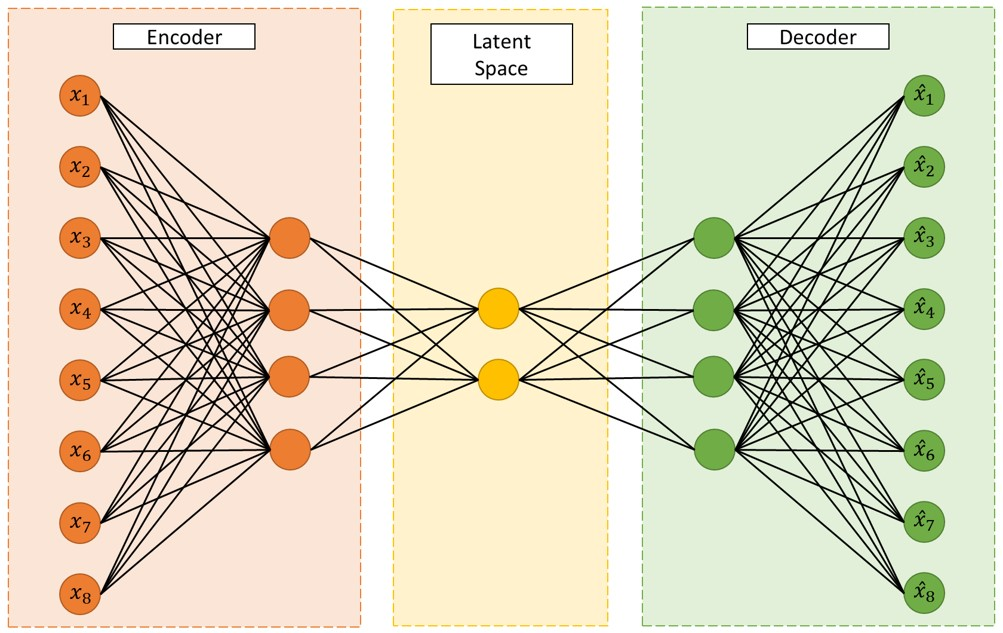

### Scikit-Learn

In [27]:
class SklearnAutoencoder():

    def __init__(self, encoding_factor=0.3, threshold_quantile=0.95, learning_rate=0.001):
        self.encoding_factor = encoding_factor
        self.threshold_quantile = threshold_quantile
        self.model = MLPRegressor(learning_rate_init=learning_rate)
        self.threshold = None
        self.log = {
            'train': None,
            'evaluate_total': None,
            'evaluate_sample': None,
            'accuracy': None,
            'precision': None,
            'recall': None,
            'f1': None,
        }

    def train(self, X, epochs=20):
        # to numpy array
        X = np.array(X)
        # set hidden layer size
        hidden_layer_size = (int(self.encoding_factor * X.shape[1]),)
        # set remaining parameters
        self.model.hidden_layer_sizes = hidden_layer_size
        self.model.max_iter = epochs
        # train model
        start_time = time.time()
        self.model.fit(X, X)
        self.log['train'] = time.time() - start_time
        # calculate threshold
        reconstruction_error = np.mean((X - self.model.predict(X))**2, axis=1)
        self.threshold = np.percentile(reconstruction_error, self.threshold_quantile*100)

        return self
    
    def evaluate(self, X, y_true):
        # to numpy array
        X = np.array(X)
        # evaluate model
        start_time = time.time()
        reconstructed_data = np.array([self.model.predict(X[[i]])[0] for i in tqdm(range(X.shape[0]))])
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X.shape[0]
        # calculate reconstruction error
        reconstruction_error = np.mean((X - reconstructed_data)**2, axis=1)
        # create labels
        y_pred = np.where(reconstruction_error > self.threshold, 1, 0)
        # calculate metrics
        self.log['accuracy'] = round(accuracy_score(y_true, y_pred), 2)
        self.log['precision'] = round(precision_score(y_true, y_pred), 2)
        self.log['recall'] = round(recall_score(y_true, y_pred), 2)
        self.log['f1'] = round(f1_score(y_true, y_pred), 2)
        # plot
        plot_classification_metrics(y_true, y_pred, plot_title='Sklearn Autoencoder')
        # return prediction labels
        return y_pred

#### Android Dataset

100%|██████████| 100/100 [00:00<00:00, 479.64it/s]


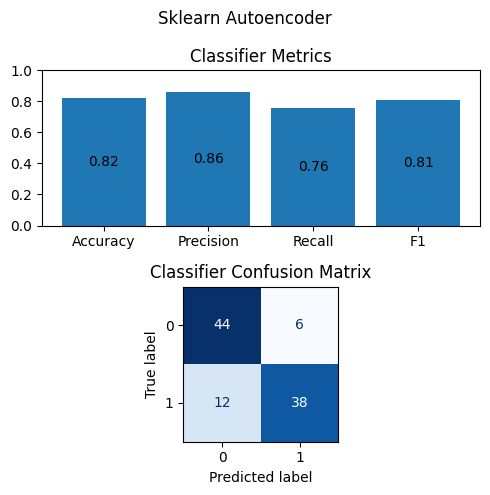

In [28]:
# initialize model
sklearn_autoencoder = SklearnAutoencoder(
    encoding_factor=0.3,
    threshold_quantile=0.95
)
# train model
sklearn_autoencoder = sklearn_autoencoder.train(xtrain_android)
# evaluate model
ypred_sklearn = sklearn_autoencoder.evaluate(xtest_android, ytest_android)

In [29]:
# display results
results = pd.DataFrame(sklearn_autoencoder.log, index=[0])
results

,train,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,1.123441,0.214113,0.002141,0.82,0.86,0.76,0.81


#### BGL Dataset

100%|██████████| 100/100 [00:00<00:00, 3904.22it/s]


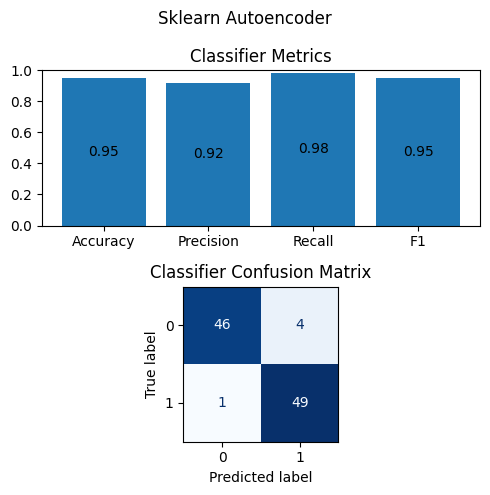

In [30]:
# initialize model
sklearn_autoencoder = SklearnAutoencoder(
    encoding_factor=0.3,
    threshold_quantile=0.95
)
# train model
sklearn_autoencoder = sklearn_autoencoder.train(xtrain_bgl)
# evaluate model
ypred_sklearn = sklearn_autoencoder.evaluate(xtest_bgl, ytest_bgl)

In [31]:
# display results
results = pd.DataFrame(sklearn_autoencoder.log, index=[0])
results

,train,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,1.864237,0.031208,0.000312,0.95,0.92,0.98,0.95


#### Hadoop Dataset

100%|██████████| 100/100 [00:00<00:00, 4713.12it/s]


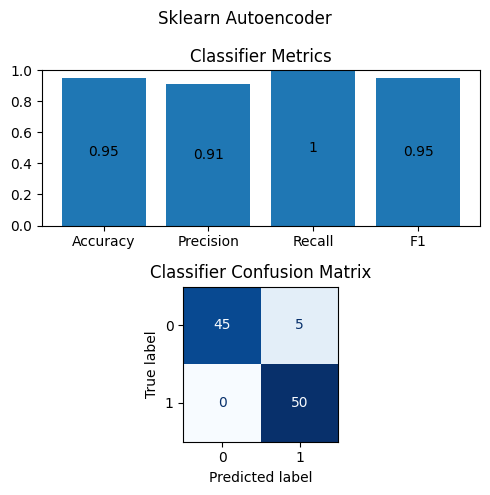

In [32]:
# initialize model
sklearn_autoencoder = SklearnAutoencoder(
    encoding_factor=0.3,
    threshold_quantile=0.95
)
# train model
sklearn_autoencoder = sklearn_autoencoder.train(xtrain_hadoop)
# evaluate model
ypred_sklearn = sklearn_autoencoder.evaluate(xtest_hadoop, ytest_hadoop)

In [33]:
# display results
results = pd.DataFrame(sklearn_autoencoder.log, index=[0])
results

,train,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,0.92662,0.026015,0.00026,0.95,0.91,1.0,0.95


### Concrete

In [34]:
class ConcreteAutoencoder():

    def __init__(self, n_bits=2, encoding_factor=0.3, threshold_quantile=0.95, learning_rate=0.001):
        self.n_bits = n_bits
        self.encoding_factor = encoding_factor
        self.threshold_quantile = threshold_quantile
        self.model = ConcreteMLPRegressor(lr=learning_rate, verbose=0)
        self.threshold = None
        self.fhe_circuit = None
        self.log = {
            'n_bits': n_bits,
            'train': None,
            'compile': None,
            'keygen': None,
            'evaluate_total': None,
            'evaluate_sample': None,
            'accuracy': None,
            'precision': None,
            'recall': None,
            'f1': None,
        }

    def train(self, X, epochs=20):
        # to numpy array
        X = np.array(X)
        # set set remaining parameters
        self.model.module__n_layers = 2
        self.model.module__n_w_bits = self.n_bits
        self.model.module__n_a_bits = self.n_bits
        self.model.module__n_hidden_neurons_multiplier = self.encoding_factor
        self.model.max_epochs = epochs
        # train model
        start_time = time.time()
        self.model.fit(X, X)
        self.log['train'] = time.time() - start_time
        # calculate threshold
        reconstruction_error = np.mean((X - self.model.predict(X))**2, axis=1)
        self.threshold = np.percentile(reconstruction_error, self.threshold_quantile*100)
        # compile concrete model
        start_time = time.time()
        self.fhe_circuit = self.model.compile(X[:100])
        self.log['compile'] = time.time() - start_time

        return self
    
    def evaluate(self, X, y_true,fhe='simulate'):
        # to numpy array
        X = np.array(X)
        # key generation
        start_time = time.time()
        self.fhe_circuit.keygen(force=True)
        self.log['keygen'] = time.time() - start_time
        # evaluate model
        start_time = time.time()
        reconstructed_data = np.array([self.model.predict(X[[i]], fhe=fhe)[0] for i in tqdm(range(X.shape[0]))])
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X.shape[0]
        # calculate reconstruction error
        reconstruction_error = np.mean((X - reconstructed_data)**2, axis=1)
        # create labels
        y_pred = np.where(reconstruction_error > self.threshold, 1, 0)
        # calculate metrics
        self.log['accuracy'] = round(accuracy_score(y_true, y_pred), 2)
        self.log['precision'] = round(precision_score(y_true, y_pred), 2)
        self.log['recall'] = round(recall_score(y_true, y_pred), 2)
        self.log['f1'] = round(f1_score(y_true, y_pred), 2)
        # plot
        plot_classification_metrics(y_true, y_pred, plot_title=f'Concrete Autoencoder (n_bits={self.n_bits})')
        # return prediction labels
        return y_pred

#### Android Dataset

100%|██████████| 50/50 [00:00<00:00, 794.66it/s]


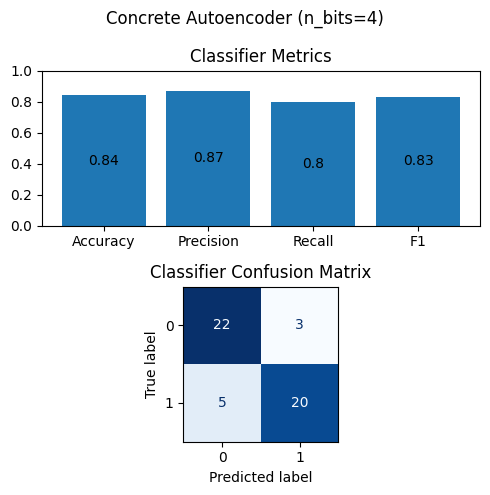

In [35]:
# fine-tune model

# initialize model
concrete_autoencoder = ConcreteAutoencoder(
    n_bits=4,
    encoding_factor=0.3,
    threshold_quantile=0.95
)

# train model
concrete_autoencoder = concrete_autoencoder.train(xtrain_android)

# evaluate model on validation set
ypred_concrete = concrete_autoencoder.evaluate(xval_android, yval_android, fhe='simulate')

100%|██████████| 100/100 [03:48<00:00,  2.28s/it]


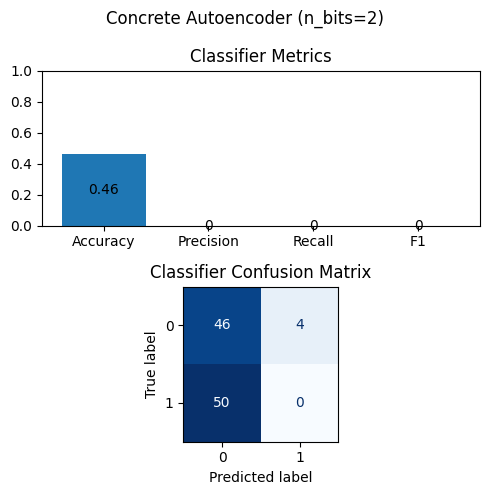

100%|██████████| 100/100 [05:26<00:00,  3.27s/it]


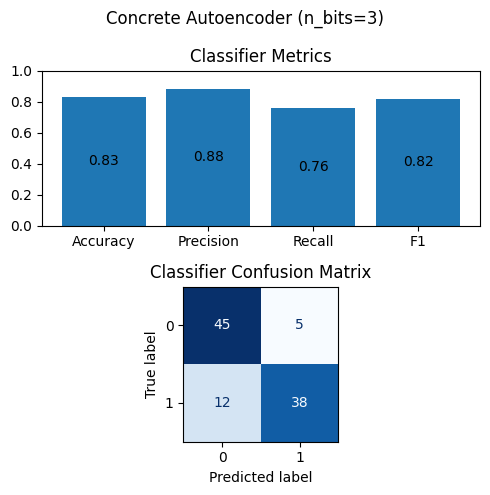

100%|██████████| 100/100 [08:06<00:00,  4.87s/it]


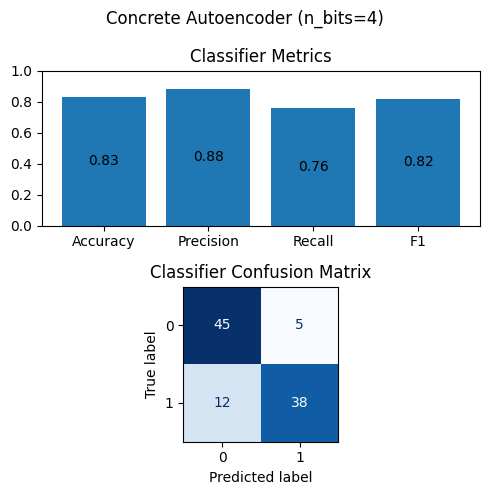

100%|██████████| 100/100 [11:32<00:00,  6.92s/it]


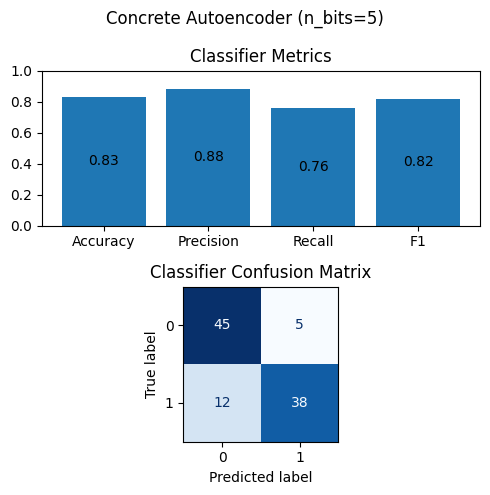

100%|██████████| 100/100 [25:54<00:00, 15.54s/it]


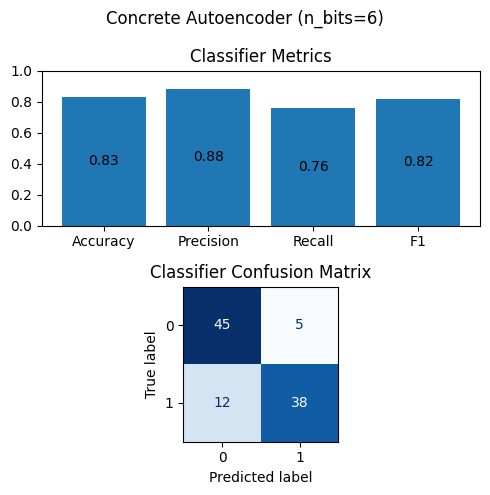

In [36]:
results = []

for n_bits in range(2,7):
    # initialize model
    concrete_autoencoder = ConcreteAutoencoder(
        n_bits=n_bits,
        encoding_factor=0.3,
        threshold_quantile=0.95
    )
    # train model
    concrete_autoencoder = concrete_autoencoder.train(xtrain_android)
    # evaluate model
    ypred_concrete = concrete_autoencoder.evaluate(xtest_android, ytest_android, fhe=fhe_mode)
    # append results to list
    results.append(concrete_autoencoder.log)

In [37]:
# display results
results = pd.DataFrame(results)
results

,n_bits,train,compile,keygen,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,2,3.141634,0.429461,1.855781,228.315369,2.283154,0.46,0.00,0.00,0.00
1,3,3.656220,0.440885,3.749576,326.701303,3.267013,0.83,0.88,0.76,0.82
2,4,3.587999,0.424704,11.261863,486.834415,4.868344,0.83,0.88,0.76,0.82
3,5,3.410400,0.484173,16.108094,692.139042,6.921390,0.83,0.88,0.76,0.82
4,6,3.271458,0.642970,105.263959,1554.467975,15.544680,0.83,0.88,0.76,0.82


#### BGL Dataset

100%|██████████| 50/50 [00:00<00:00, 746.53it/s]


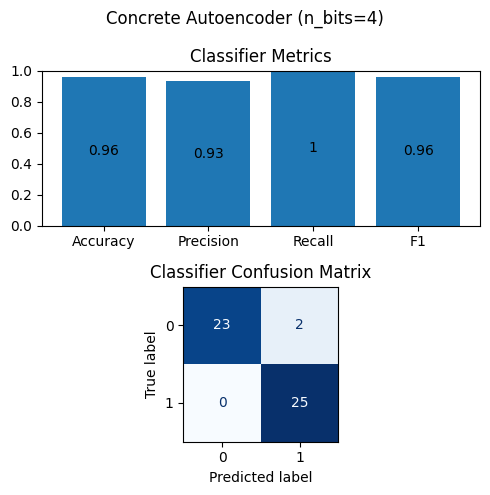

In [38]:
# fine-tune model

# initialize model
concrete_autoencoder = ConcreteAutoencoder(
    n_bits=4,
    encoding_factor=0.3,
    threshold_quantile=0.95
)

# train model
concrete_autoencoder = concrete_autoencoder.train(xtrain_bgl)

# evaluate model on validation set
ypred_concrete = concrete_autoencoder.evaluate(xval_bgl, yval_bgl, fhe='simulate')

100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


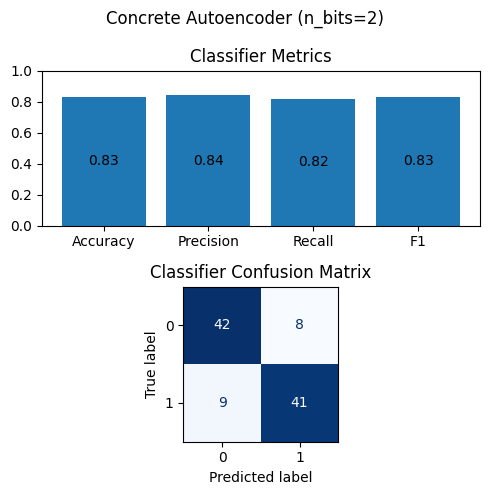

100%|██████████| 100/100 [03:35<00:00,  2.15s/it]


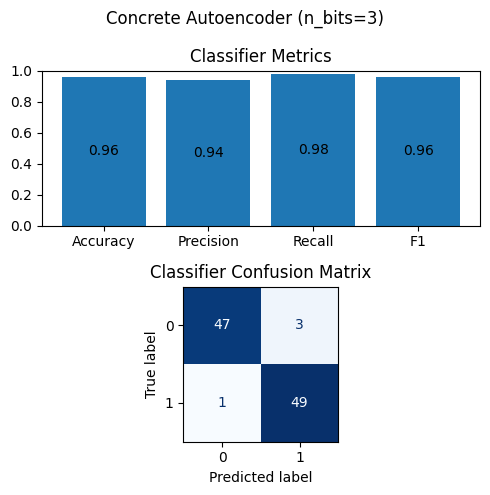

100%|██████████| 100/100 [04:03<00:00,  2.44s/it]


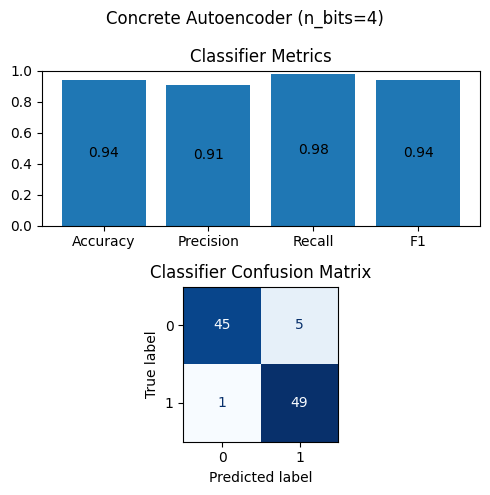

100%|██████████| 100/100 [07:13<00:00,  4.34s/it]


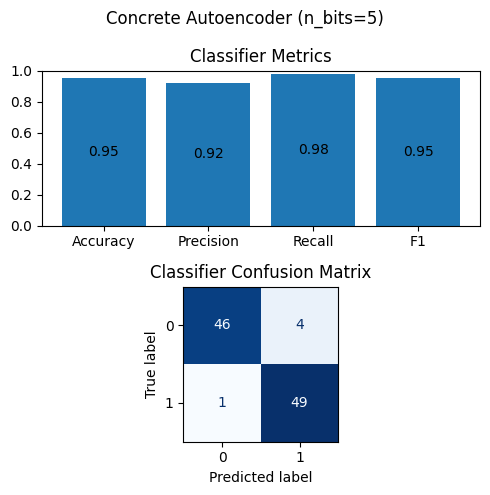

100%|██████████| 100/100 [17:37<00:00, 10.57s/it]


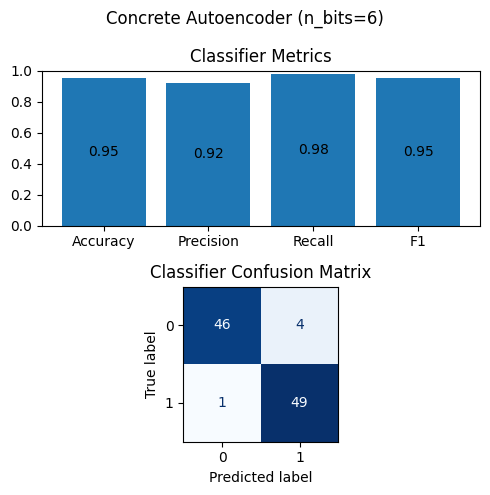

In [39]:
results = []

for n_bits in range(2,7):
    # initialize model
    concrete_autoencoder = ConcreteAutoencoder(
        n_bits=n_bits,
        encoding_factor=0.3,
        threshold_quantile=0.95
    )
    # train model
    concrete_autoencoder = concrete_autoencoder.train(xtrain_bgl)
    # evaluate model
    ypred_concrete = concrete_autoencoder.evaluate(xtest_bgl, ytest_bgl, fhe=fhe_mode)
    # append results to list
    results.append(concrete_autoencoder.log)

In [40]:
# display results
results = pd.DataFrame(results)
results

,n_bits,train,compile,keygen,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,2,2.900356,0.485344,1.825325,115.550425,1.155504,0.83,0.84,0.82,0.83
1,3,2.452983,0.387370,3.763396,215.482641,2.154826,0.96,0.94,0.98,0.96
2,4,2.485355,0.402124,3.729014,243.913576,2.439136,0.94,0.91,0.98,0.94
3,5,3.308918,0.507471,16.317445,433.969076,4.339691,0.95,0.92,0.98,0.95
4,6,2.539237,0.481198,103.149106,1057.106427,10.571064,0.95,0.92,0.98,0.95


#### Hadoop Dataset

100%|██████████| 50/50 [00:00<00:00, 791.72it/s]


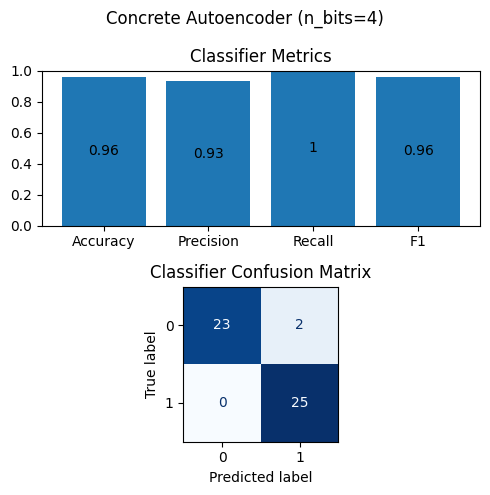

In [41]:
# fine-tune model

# initialize model
concrete_autoencoder = ConcreteAutoencoder(
    n_bits=4,
    encoding_factor=0.3,
    threshold_quantile=0.95
)

# train model
concrete_autoencoder = concrete_autoencoder.train(xtrain_hadoop)

# evaluate model on validation set
ypred_concrete = concrete_autoencoder.evaluate(xval_hadoop, yval_hadoop, fhe='simulate')

100%|██████████| 100/100 [02:13<00:00,  1.34s/it]


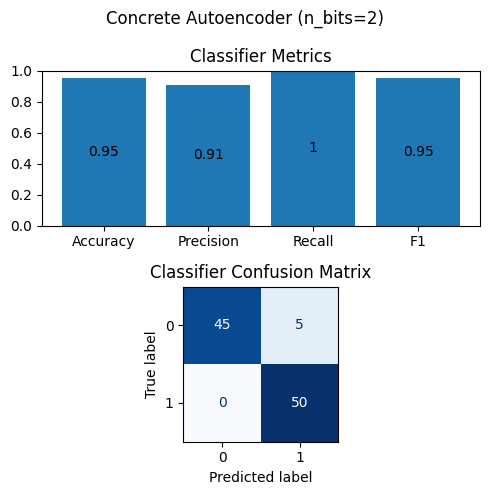

100%|██████████| 100/100 [04:02<00:00,  2.42s/it]


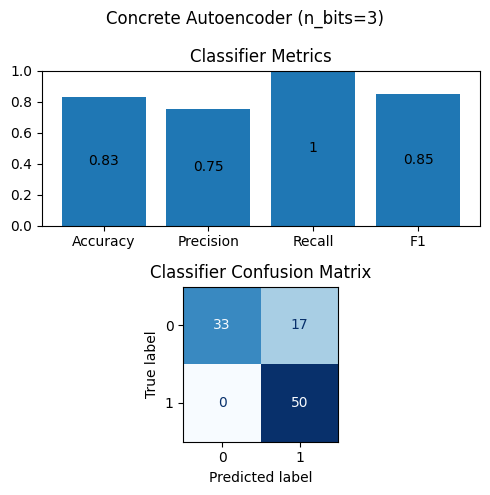

100%|██████████| 100/100 [05:23<00:00,  3.23s/it]


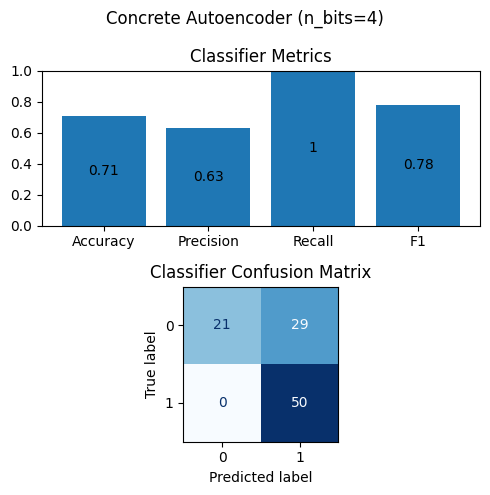

100%|██████████| 100/100 [06:41<00:00,  4.02s/it]


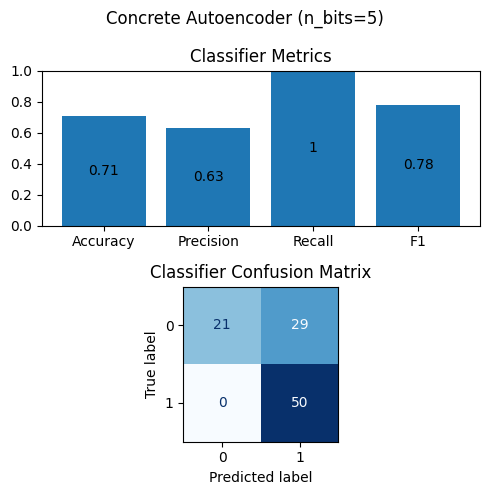

100%|██████████| 100/100 [15:29<00:00,  9.30s/it]


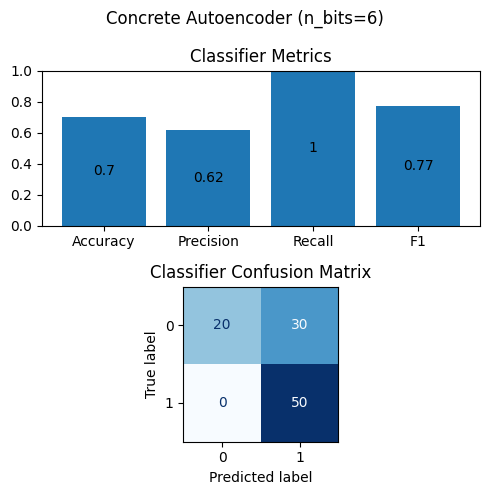

In [42]:
results = []

for n_bits in range(2,7):
    # initialize model
    concrete_autoencoder = ConcreteAutoencoder(
        n_bits=n_bits,
        encoding_factor=0.3,
        threshold_quantile=0.95
    )
    # train model
    concrete_autoencoder = concrete_autoencoder.train(xtrain_hadoop)
    # evaluate model
    ypred_concrete = concrete_autoencoder.evaluate(xtest_hadoop, ytest_hadoop, fhe=fhe_mode)
    # append results to list
    results.append(concrete_autoencoder.log)

In [43]:
# display results
results = pd.DataFrame(results)
results

,n_bits,train,compile,keygen,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,2,3.309432,0.461605,1.837988,133.543277,1.335433,0.95,0.91,1.0,0.95
1,3,5.311338,0.559600,3.134429,242.252820,2.422528,0.83,0.75,1.0,0.85
2,4,3.208740,0.483285,12.301970,323.014765,3.230148,0.71,0.63,1.0,0.78
3,5,3.733555,0.480540,18.655112,401.932037,4.019320,0.71,0.63,1.0,0.78
4,6,3.193735,0.520739,88.934641,929.557846,9.295578,0.70,0.62,1.0,0.77
